In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
from astropy.table import Table
from numpy import random
import scipy
import matplotlib.pyplot as plt
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData
from clmm import Cosmology
from clmm.support import mock_data as mock
import pandas as pd
import numpy as np
import pyccl as ccl
import sacc
clmm.__version__

'1.4.0'

Generating Random Custers

In [2]:
np.random.seed(11)

In [3]:
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [4]:
# redshift and mass range of the galaxy clusters
z_bin = [0.1,0.6]
logm_bin = np.array([13, 15.1]) #Solar Mass

# number of clusters in the ensemble
n_clusters = 30

# random draw in the mass and redshift range (for simplicity, uniform instead of following an actual mass function)
cluster_m = 10 **((logm_bin[1] - logm_bin[0])*np.random.random(n_clusters) + logm_bin[0]) #in M_sun
cluster_z =  (z_bin[1] - z_bin[0])*np.random.random(n_clusters) + z_bin[0] 

# random normal draw of cluster concentration, around c_mean
c_mean = 4.
lnc = abs(np.log(c_mean) + 0.01*np.random.randn(n_clusters))
concentration = np.exp(lnc)

# randomly draw cluster positions on the sky
ra = np.random.random(n_clusters) * 360 #from 0 to 360 deg
sindec = np.random.random(n_clusters) * 2 - 1
dec = np.arcsin(sindec) * 180 / np.pi #from -90 to 90 deg
catalog = {
    "proxy_colname":cluster_m,
    "redshift_colname":cluster_z,
    "ra_colname": ra,
    "dec_colname":dec
}

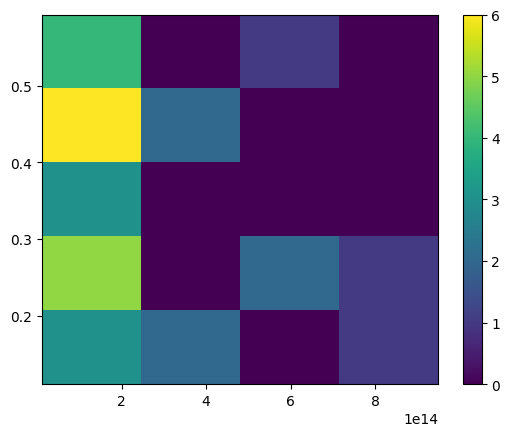

In [5]:

N_m = 5 # number of mass bins
N_z = 4 # number of redshift bins

data_lz, z_edges, richness_edges, im  = plt.hist2d(cluster_m, cluster_z,
                                       bins=[N_z, N_m]);

plt.colorbar()

In [6]:
# Adapted from Constantin Payerne's code in the CLCOSMO_sim repo

import healpy
from itertools import combinations
def compute_jackknife_covariance(catalog = None, 
                                proxy_colname = 'richness', redshift_colname = 'redshift',
                                ra_colname = 'ra', dec_colname = 'dec',
                                proxy_edges = richness_edges, z_edges = z_edges,        
                                hp_power = 7, N_delete = 1):
        r"""
        Attributes:
        -----------
        proxy_colname: str
            name of the proxy column
        redshift_colname: str
            name of the redshift column
        ra_colname: str
            name of the ra column
        dec_colname: str
            name of the dec column
        proxy_edges: array
            edges of the mass proxy bins
        z_edges: array
            edges of the redshift bins
        hp_power: int
            defines the number of healpix pixels. Healpix Nside = 2**hp_power
        N_delete: int
            number of jackknife region to delete each repetition
        Returns:
        --------
        cov_N: array
            Jackknife covariance matrix
        """
        proxy, redshift = np.array(catalog["proxy_colname"]), np.array(catalog["redshift_colname"])
        ra, dec =  np.array(catalog["ra_colname"]), np.array(catalog["dec_colname"])

        index = np.arange(len(proxy))
        healpix = healpy.ang2pix(2**hp_power, ra, dec, nest=True, lonlat=True)
        healpix_list_unique = np.unique(healpix)
        print(f'Number of JK regions: {len(healpix_list_unique)}')
        healpix_combination_delete = list(combinations(healpix_list_unique, N_delete))
        data_jack = []
        
        for i, hp_list_delete in enumerate(healpix_combination_delete):
            if (i/2000.).is_integer():
                print(i) # to track progress
            mask_in_area = np.isin(healpix, hp_list_delete)
            mask_out_area = np.invert(mask_in_area)
            data,_,_ = np.histogram2d(redshift[mask_out_area],proxy[mask_out_area],
                                            bins=[z_edges, proxy_edges])
            data_jack.append(data.flatten())
        
        data_jack = np.array(data_jack)
        N = np.stack((data_jack.astype(float)), axis = 1)
        n_jack = len(healpix_combination_delete)
        cov_N = (n_jack - 1) * np.cov(N, bias = False,ddof=0)
        coeff = (n_jack - N_delete) / (N_delete * n_jack)
        
        return cov_N * coeff

In [47]:
covariance = []
for i in range(0,20):
    cov_i = []
    for j in range (0,20):
        cov_i.append(random.randint(0,30)) 
    covariance.append(cov_i)

covariance =np.cov(covariance, bias = False,ddof=0)
print(covariance)


[[ 86.89     9.23    -9.385    5.62   -14.84     1.835   14.33    15.2
  -10.585  -15.61   -22.895  -15.68     9.26    33.525    4.69    15.86
   -9.29    -2.72    14.75   -12.69  ]
 [  9.23    64.06     1.53   -19.56    -9.73   -32.73   -10.39     3.35
   -3.02    16.63    26.91    16.74    13.57     4.     -19.07    19.52
  -23.83    14.06    38.3      6.82  ]
 [ -9.385    1.53    32.9275   1.32     3.485   -5.5525  -9.345    9.7
  -14.2225  10.89    -3.5575   9.37    13.61   -13.9375  -2.66     2.71
   20.735   12.255  -11.225    3.985 ]
 [  5.62   -19.56     1.32    75.76     9.78    11.63     4.79     0.95
   -0.63    11.27   -13.51   -27.14    10.43   -21.75    15.12   -17.62
   25.63    -7.51    -4.1    -19.52  ]
 [-14.84    -9.73     3.485    9.78    85.99    -7.185  -14.18     5.
   21.885    6.61     5.345    7.03    15.44   -12.125   10.41   -28.01
   -2.96   -18.28   -27.3     -4.81  ]
 [  1.835  -32.73    -5.5525  11.63    -7.185   86.9275   5.995    3.05
  -12.8525 -27.44

Storing In Sacc

In [48]:
s_count = sacc.Sacc()

In [49]:
# First we build the cluster count tracer
# Here we will store the richness and redshift bin information in metadata,

for i in np.arange(N_z):
    for j in np.arange(N_m):
        name = f'clusters_{i}_{j}'
        metadata = {'Mproxy_name': 'mass',
                    'Mproxy_min': richness_edges[j], 'Mproxy_max': richness_edges[j+1],
                    'z_name': 'redshift',
                    'z_min': z_edges[i], 'z_max': z_edges[i+1],
                    'sky_area': 439.78986
                    
        }
        s_count.add_tracer('misc', name, metadata=metadata)
        

In [50]:
# One of our identifiers is a standard type name that is predefined
cluster_count = sacc.standard_types.cluster_mass_count_wl

for i in range(N_z): 
    for j in range(N_m): 
        # Cluster number counts data
        tracer = f'clusters_{i}_{j}'
        value = data_lz[i][j]
        s_count.add_data_point(cluster_count, (tracer,), int(value), err=1.)

In [51]:

s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("clusters.sacc", overwrite=True)

In [52]:
sacc_data = sacc.Sacc.load_fits("./clusters.sacc")
print(sacc_data.data[0].__dict__)
print(sacc_data.data[0].value)

{'data_type': 'cluster_mass_count_wl', 'tracers': ('clusters_0_0',), 'value': 3, 'tags': {'err': 1.0}}
3


In [53]:
tracer = []
z_min = []
z_max = []
nz = []
metadata = []
for i in range (0, len(sacc_data.data)):
    tracer.append(sacc_data.data[i].tracers[0])
    print(tracer[i])
    metadata.append(sacc_data.tracers[tracer[i]].metadata)
    z_min.append(metadata[i]["z_min"])
    z_max.append(metadata[i]["z_max"])
    nz.append(sacc_data.data[i].value)

clusters_0_0
clusters_0_1
clusters_0_2
clusters_0_3
clusters_0_4
clusters_1_0
clusters_1_1
clusters_1_2
clusters_1_3
clusters_1_4
clusters_2_0
clusters_2_1
clusters_2_2
clusters_2_3
clusters_2_4
clusters_3_0
clusters_3_1
clusters_3_2
clusters_3_3
clusters_3_4


In [54]:
print(sacc_data.indices("counts", tuple("cluster_0_0"))
)

[]


/usr/local/lib/python3.8/dist-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
